In [1]:
import matplotlib.pyplot as plt
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob
import os
import re
import sys 

In [2]:
adata = sc.read_h5ad('/data/jiangjunyao/AEGAS_data/fate/iep_atac_full.h5ad')
adata

AnnData object with n_obs × n_vars = 13268 × 354352
    obs: 'nCount_RNA', 'nFeature_RNA', 'celltype', 'lineage', 'barcodes', 'UMAP_1', 'UMAP_2', 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'TSSEnrichment', 'clusters_lsi', 'clusters_har', 'Sample2', 'ReadsInPeaks', 'FRIP', 'Sample3', 'state_grp', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'md_fate', 'md_fate_impute', 'clusters_lsi2', 'alt_cellNames', 'final_clusters', 'final_clusters_2', 'md_fate_impute_2', 'sample_information', 'time_information'
    var: 'name'

In [3]:
min_cells = int(adata.shape[0] * 0.025)
print(min_cells)
sc.pp.filter_genes(adata, min_cells=min_cells)
adata.var["name"]  = adata.var_names
split_interval = adata.var["name"].str.split("-", expand=True)
adata.var["chr"] = split_interval[0]
adata.var["start"] = split_interval[1].astype(int)
adata.var["end"] = split_interval[2].astype(int)
mask = adata.var["chr"].str.startswith("chr")
adata = adata[:, mask].copy()

331


In [4]:
adata

AnnData object with n_obs × n_vars = 13268 × 83305
    obs: 'nCount_RNA', 'nFeature_RNA', 'celltype', 'lineage', 'barcodes', 'UMAP_1', 'UMAP_2', 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'TSSEnrichment', 'clusters_lsi', 'clusters_har', 'Sample2', 'ReadsInPeaks', 'FRIP', 'Sample3', 'state_grp', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'md_fate', 'md_fate_impute', 'clusters_lsi2', 'alt_cellNames', 'final_clusters', 'final_clusters_2', 'md_fate_impute_2', 'sample_information', 'time_information'
    var: 'name', 'n_cells', 'chr', 'start', 'end'

In [5]:
scvi.data.add_dna_sequence(
            adata,
            genome_name="mm10",
            genome_dir="/data/jiangjunyao/software/scbasset/data",
            chr_var_key="chr",
            start_var_key="start",
            end_var_key="end",
            install_genome = False
        )

Working...: 100%|██████████| 20/20 [01:21<00:00,  4.07s/it]


In [6]:
##start train
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(bdata, layer="binary", dna_code_key="dna_code")
bas = scvi.external.SCBASSET(bdata)
bas.train(precision=16,batch_size=256)
latent = bas.get_latent_representation()
adata.obsm["X_scbasset"] = latent

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


INFO     Using column names from columns of adata.obsm['dna_code']                                                 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/data/jiangjunyao/miniconda3/envs/normal/lib/python3.9/site-packages/lightning/fabric/connector.py:558: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
/data/jiangjunyao/miniconda3/envs/normal/lib/python3.9/site-packages/lightning/pytorch/plugins/precision/amp.py:54: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has

Epoch 903/1000:  90%|█████████ | 903/1000 [3:09:31<20:21, 12.59s/it, v_num=1, train_loss_step=0.218, train_loss_epoch=0.223]  
Monitored metric auroc_train did not improve in the last 45 records. Best score: 0.783. Signaling Trainer to stop.


In [7]:
sc.pp.neighbors(adata, use_rep="X_scbasset")

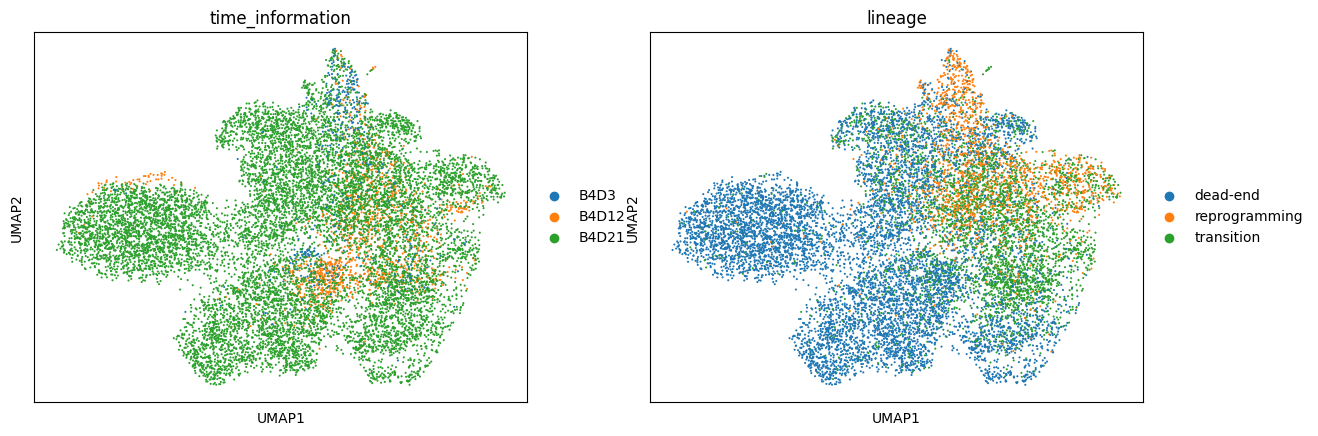

In [8]:
sc.tl.umap(adata,min_dist=0.5)
sc.pl.umap(adata,color=['time_information','lineage'])

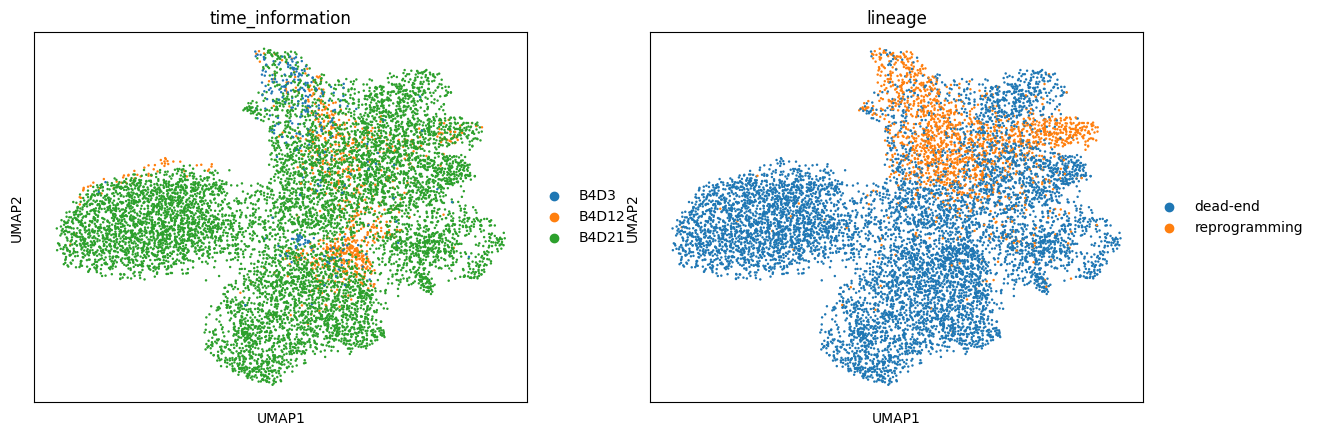

In [9]:
adata_no_tran = adata[adata.obs.lineage!='transition']
sc.pp.neighbors(adata_no_tran, use_rep="X_scbasset")
sc.tl.umap(adata_no_tran,min_dist=0.5)
sc.pl.umap(adata_no_tran,color=['time_information','lineage'])

In [11]:
adata2 = sc.read_h5ad('/data/jiangjunyao/AEGAS_data/fate/iep_atac_full.h5ad')
adata2.obsm =adata.obsm

In [12]:
adata2.obs.celltype.value_counts()

de_3       3113
de_1       2579
trans_3    1831
trans_1    1501
trans_2    1424
trans_4     841
rep_1       602
de_2        576
rep_2       308
early_2     258
early_5     129
rep_3        60
trans_8      23
early_3       8
trans_6       8
trans_7       5
early_4       1
trans_5       1
Name: celltype, dtype: int64

In [15]:
adata2.obs['celltype'] = adata.obs['time_information']
adata_no_tran = adata2[adata2.obs.lineage!='transition']

In [17]:
adata_no_tran

View of AnnData object with n_obs × n_vars = 9616 × 354352
    obs: 'nCount_RNA', 'nFeature_RNA', 'celltype', 'lineage', 'barcodes', 'UMAP_1', 'UMAP_2', 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'TSSEnrichment', 'clusters_lsi', 'clusters_har', 'Sample2', 'ReadsInPeaks', 'FRIP', 'Sample3', 'state_grp', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'md_fate', 'md_fate_impute', 'clusters_lsi2', 'alt_cellNames', 'final_clusters', 'final_clusters_2', 'md_fate_impute_2', 'sample_information', 'time_information'
    var: 'name'
    obsm: 'X_scbasset', 'X_umap'

In [16]:
adata2.write_h5ad('/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep.prcessed_ATAC_three_fate.h5ad')
adata_no_tran.write_h5ad('/data/jiangjunyao/easyGRN/processed_data/celltag_multi_iep.prcessed_ATAC_two_fate.h5ad')